# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [50]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   book    1206 non-null   object
 1   dex     1206 non-null   int64 
 2   cha     1206 non-null   int64 
 3   str     1206 non-null   int64 
 4   wis     1206 non-null   int64 
 5   level   1206 non-null   int64 
 6   ac      1206 non-null   int64 
 7   int     1206 non-null   int64 
 8   hp      1206 non-null   int64 
 9   con     1206 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 103.6+ KB


In [52]:
df.head()

,book,dex,cha,str,wis,level,ac,int,hp,con
0,Pathfinder Bestiary,2,1,7,2,10,29,1,215,5
1,Pathfinder Bestiary,0,1,9,2,10,28,-4,220,5
2,Pathfinder Bestiary,3,-2,7,3,8,25,-4,175,6
3,Pathfinder Bestiary,4,6,7,5,17,41,6,315,5
4,Pathfinder Bestiary,3,1,-5,1,1,16,-1,20,1


###### Level

In [53]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [54]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [55]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


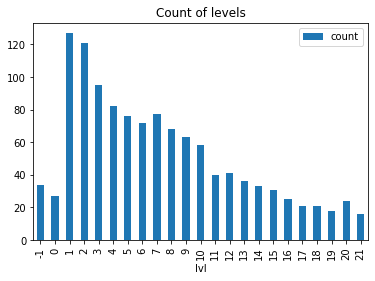

In [56]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [57]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [58]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [59]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [60]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [61]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 8
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [62]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.45
RMSE: 0.67
MAE: 0.47


In [64]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "basic", mse, rmse, mae]

In [65]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.31
RMSE test: 0.67


###### MAE by level

In [66]:
from training.results import plot_mae_by_level

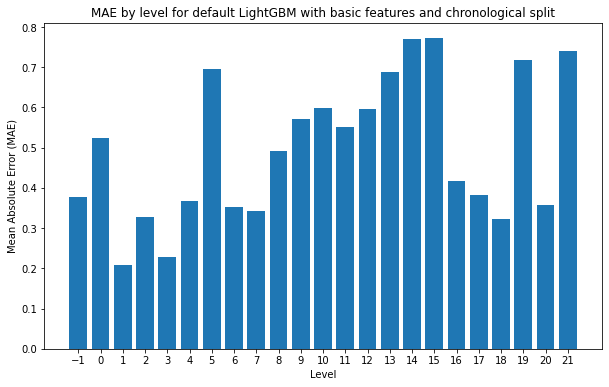

In [67]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and chronological split",
)

In [68]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.45
RMSE: 0.67

Round type: round
MSE: 0.50
RMSE: 0.71

Round type: 0.33
MSE: 0.50
RMSE: 0.71

Round type: 0.45
MSE: 0.48
RMSE: 0.70



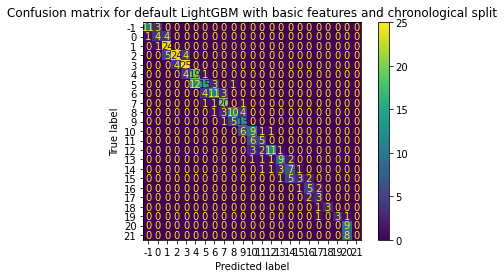

In [69]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with basic features and chronological split",
)

#### Tuning

In [70]:
from training.results import assess_regression_model

In [71]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-04 19:52:29,802] A new study created in memory with name: no-name-65d69c53-d34f-49d8-a6c8-67606883aa88
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.23065 + 0.0519896
[200]	cv_agg's l2: 0.220829 + 0.0526086
[300]	cv_agg's l2: 0.220005 + 0.0518411


feature_fraction, val_score: 0.219730:  14%|######4                                      | 1/7 [00:01<00:10,  1.67s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.21973 + 0.0519287
[100]	cv_agg's l2: 0.30348 + 0.0575157
[200]	cv_agg's l2: 0.269105 + 0.0518645
[300]	cv_agg's l2: 0.255561 + 0.0488546


feature_fraction, val_score: 0.219730:  29%|############8                                | 2/7 [00:03<00:09,  1.94s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.21973 + 0.0519287
[100]	cv_agg's l2: 0.234102 + 0.0514901
[200]	cv_agg's l2: 0.232561 + 0.0496082
[300]	cv_agg's l2: 0.23456 + 0.0509794


feature_fraction, val_score: 0.219730:  43%|###################2                         | 3/7 [00:06<00:08,  2.21s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.21973 + 0.0519287
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


feature_fraction, val_score: 0.214962:  57%|#########################7                   | 4/7 [00:14<00:13,  4.64s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.2264 + 0.041806
[200]	cv_agg's l2: 0.222563 + 0.041863
[300]	cv_agg's l2: 0.225178 + 0.0447023
[400]	cv_agg's l2: 0.227732 + 0.0465919


feature_fraction, val_score: 0.214962:  71%|################################1            | 5/7 [00:22<00:11,  5.77s/it]

[500]	cv_agg's l2: 0.230437 + 0.0475804
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.232132 + 0.0448183
[200]	cv_agg's l2: 0.229061 + 0.0446586
[300]	cv_agg's l2: 0.231512 + 0.0467566
[400]	cv_agg's l2: 0.233897 + 0.0478922


feature_fraction, val_score: 0.214962:  86%|######################################5      | 6/7 [00:29<00:06,  6.09s/it]

[500]	cv_agg's l2: 0.236282 + 0.0479595
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.2264 + 0.041806
[200]	cv_agg's l2: 0.222563 + 0.041863
[300]	cv_agg's l2: 0.225178 + 0.0447023
[400]	cv_agg's l2: 0.227732 + 0.0465919


feature_fraction, val_score: 0.214962: 100%|#############################################| 7/7 [00:35<00:00,  5.07s/it]


[500]	cv_agg's l2: 0.230437 + 0.0475804
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822


num_leaves, val_score: 0.214962:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:   5%|##5                                               | 1/20 [00:06<01:59,  6.27s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.248927 + 0.0382657
[200]	cv_agg's l2: 0.230577 + 0.0376916
[300]	cv_agg's l2: 0.223073 + 0.034437
[400]	cv_agg's l2: 0.220036 + 0.0333456


num_leaves, val_score: 0.214962:  10%|#####                                             | 2/20 [00:08<01:13,  4.09s/it]

[500]	cv_agg's l2: 0.217843 + 0.0314767
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:  15%|#######5                                          | 3/20 [00:14<01:23,  4.91s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:  20%|##########                                        | 4/20 [00:20<01:25,  5.37s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:  25%|############5                                     | 5/20 [00:26<01:24,  5.66s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:  30%|###############                                   | 6/20 [00:33<01:21,  5.80s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:  35%|#################5                                | 7/20 [00:39<01:18,  6.01s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:  40%|####################                              | 8/20 [00:46<01:16,  6.37s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:  45%|######################5                           | 9/20 [00:52<01:09,  6.30s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:  50%|########################5                        | 10/20 [00:59<01:03,  6.30s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:  55%|##########################9                      | 11/20 [01:04<00:55,  6.18s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:  60%|#############################4                   | 12/20 [01:11<00:49,  6.22s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:  65%|###############################8                 | 13/20 [01:17<00:43,  6.15s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:  70%|##################################3              | 14/20 [01:24<00:38,  6.36s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:  75%|####################################7            | 15/20 [01:30<00:32,  6.40s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:  80%|#######################################2         | 16/20 [01:38<00:27,  6.86s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:  85%|#########################################6       | 17/20 [01:44<00:20,  6.71s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.245213 + 0.0332126
[200]	cv_agg's l2: 0.228775 + 0.0351932
[300]	cv_agg's l2: 0.223123 + 0.0344523
[400]	cv_agg's l2: 0.220734 + 0.0339122


num_leaves, val_score: 0.214962:  90%|############################################1    | 18/20 [01:48<00:11,  5.81s/it]

[500]	cv_agg's l2: 0.219289 + 0.0349151
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962:  95%|##############################################5  | 19/20 [01:54<00:05,  5.95s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


num_leaves, val_score: 0.214962: 100%|#################################################| 20/20 [02:02<00:00,  6.12s/it]


[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822


bagging, val_score: 0.214962:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.288471 + 0.0526998
[200]	cv_agg's l2: 0.267946 + 0.0532901
[300]	cv_agg's l2: 0.265747 + 0.0493055
[400]	cv_agg's l2: 0.26487 + 0.0478038


bagging, val_score: 0.214962:  10%|#####3                                               | 1/10 [00:03<00:33,  3.71s/it]

[500]	cv_agg's l2: 0.263149 + 0.0454667
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.239307 + 0.0364135
[200]	cv_agg's l2: 0.226053 + 0.0405637
[300]	cv_agg's l2: 0.223488 + 0.0415344
[400]	cv_agg's l2: 0.222943 + 0.042154


bagging, val_score: 0.214962:  20%|##########6                                          | 2/10 [00:10<00:43,  5.40s/it]

[500]	cv_agg's l2: 0.223223 + 0.0414063
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.264427 + 0.0341808
[200]	cv_agg's l2: 0.24227 + 0.0398138
[300]	cv_agg's l2: 0.236803 + 0.038799
[400]	cv_agg's l2: 0.23465 + 0.036382


bagging, val_score: 0.214962:  30%|###############9                                     | 3/10 [00:15<00:36,  5.25s/it]

[500]	cv_agg's l2: 0.233323 + 0.0340258
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.318912 + 0.0451634
[200]	cv_agg's l2: 0.291962 + 0.0459611
[300]	cv_agg's l2: 0.289745 + 0.0438299
[400]	cv_agg's l2: 0.277297 + 0.0462942


bagging, val_score: 0.214962:  40%|#####################2                               | 4/10 [00:18<00:27,  4.52s/it]

[500]	cv_agg's l2: 0.279575 + 0.0488696
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.234513 + 0.0335444
[200]	cv_agg's l2: 0.221744 + 0.0348377
[300]	cv_agg's l2: 0.218141 + 0.0354253
[400]	cv_agg's l2: 0.218018 + 0.0355015


bagging, val_score: 0.214962:  50%|##########################5                          | 5/10 [00:25<00:26,  5.37s/it]

[500]	cv_agg's l2: 0.218182 + 0.0360085
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.266378 + 0.0386122
[200]	cv_agg's l2: 0.24336 + 0.0348558
[300]	cv_agg's l2: 0.235184 + 0.0339332
[400]	cv_agg's l2: 0.232974 + 0.03395


bagging, val_score: 0.214962:  60%|###############################8                     | 6/10 [00:31<00:21,  5.43s/it]

[500]	cv_agg's l2: 0.233123 + 0.0346541
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.287921 + 0.0517156
[200]	cv_agg's l2: 0.273322 + 0.0502987
[300]	cv_agg's l2: 0.261031 + 0.0496734
[400]	cv_agg's l2: 0.255431 + 0.0452656


bagging, val_score: 0.214962:  70%|#####################################                | 7/10 [00:35<00:15,  5.12s/it]

[500]	cv_agg's l2: 0.256801 + 0.044692
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.244551 + 0.0345886
[200]	cv_agg's l2: 0.225626 + 0.0337973
[300]	cv_agg's l2: 0.221398 + 0.0373195
[400]	cv_agg's l2: 0.21867 + 0.0374371


bagging, val_score: 0.214962:  80%|##########################################4          | 8/10 [00:41<00:10,  5.39s/it]

[500]	cv_agg's l2: 0.216973 + 0.0367948
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.282959 + 0.0329713
[200]	cv_agg's l2: 0.267702 + 0.044127
[300]	cv_agg's l2: 0.265074 + 0.0452131
[400]	cv_agg's l2: 0.262531 + 0.0449694


bagging, val_score: 0.214962:  90%|###############################################7     | 9/10 [00:46<00:05,  5.07s/it]

[500]	cv_agg's l2: 0.261189 + 0.0419621
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.244174 + 0.0310714
[200]	cv_agg's l2: 0.225045 + 0.0324404
[300]	cv_agg's l2: 0.219365 + 0.0331478
[400]	cv_agg's l2: 0.217809 + 0.0328386
[500]	cv_agg's l2: 0.217952 + 0.0323685


bagging, val_score: 0.214962: 100%|####################################################| 10/10 [00:54<00:00,  5.42s/it]


Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822


feature_fraction_stage2, val_score: 0.214962:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.30348 + 0.0575157
[200]	cv_agg's l2: 0.269105 + 0.0518645
[300]	cv_agg's l2: 0.255561 + 0.0488546
[400]	cv_agg's l2: 0.250634 + 0.0469363


feature_fraction_stage2, val_score: 0.214962:  17%|######3                               | 1/6 [00:10<00:54, 10.82s/it]

[500]	cv_agg's l2: 0.248606 + 0.045454
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


feature_fraction_stage2, val_score: 0.214962:  33%|############6                         | 2/6 [00:16<00:32,  8.06s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


feature_fraction_stage2, val_score: 0.214962:  50%|###################                   | 3/6 [00:23<00:21,  7.30s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.23065 + 0.0519896
[200]	cv_agg's l2: 0.220829 + 0.0526086
[300]	cv_agg's l2: 0.220005 + 0.0518411
[400]	cv_agg's l2: 0.221839 + 0.0531079


feature_fraction_stage2, val_score: 0.214962:  67%|#########################3            | 4/6 [00:29<00:13,  6.99s/it]

[500]	cv_agg's l2: 0.222566 + 0.0529545
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


feature_fraction_stage2, val_score: 0.214962:  83%|###############################6      | 5/6 [00:38<00:07,  7.41s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


feature_fraction_stage2, val_score: 0.214962: 100%|######################################| 6/6 [00:44<00:00,  7.40s/it]


[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822


regularization_factors, val_score: 0.214962:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.23538 + 0.0347367
[200]	cv_agg's l2: 0.223931 + 0.0373394
[300]	cv_agg's l2: 0.221144 + 0.0389083
[400]	cv_agg's l2: 0.220379 + 0.0393437


regularization_factors, val_score: 0.214962:   5%|#9                                    | 1/20 [00:05<01:52,  5.94s/it]

[500]	cv_agg's l2: 0.220744 + 0.0394595
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


regularization_factors, val_score: 0.214962:  10%|###8                                  | 2/20 [00:12<01:48,  6.02s/it]

[500]	cv_agg's l2: 0.215604 + 0.0343367
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.279708 + 0.0352799
[200]	cv_agg's l2: 0.264621 + 0.0363634
[300]	cv_agg's l2: 0.262729 + 0.0371984
[400]	cv_agg's l2: 0.262716 + 0.0372072


regularization_factors, val_score: 0.214962:  15%|#####7                                | 3/20 [00:13<01:08,  4.04s/it]

[500]	cv_agg's l2: 0.262715 + 0.0372076
Early stopping, best iteration is:
[406]	cv_agg's l2: 0.214962 + 0.0340822
[100]	cv_agg's l2: 0.232926 + 0.0305556
[200]	cv_agg's l2: 0.221535 + 0.0335856
[300]	cv_agg's l2: 0.216733 + 0.0337979
[400]	cv_agg's l2: 0.215104 + 0.0344903


regularization_factors, val_score: 0.214823:  20%|#######6                              | 4/20 [00:21<01:29,  5.59s/it]

Early stopping, best iteration is:
[393]	cv_agg's l2: 0.214823 + 0.0339775
[100]	cv_agg's l2: 0.233291 + 0.0307311
[200]	cv_agg's l2: 0.221304 + 0.0335006
[300]	cv_agg's l2: 0.217443 + 0.0340473
[400]	cv_agg's l2: 0.216283 + 0.0348472


regularization_factors, val_score: 0.214823:  25%|#########5                            | 5/20 [00:27<01:26,  5.77s/it]

Early stopping, best iteration is:
[393]	cv_agg's l2: 0.214823 + 0.0339775
[100]	cv_agg's l2: 0.232926 + 0.0305554
[200]	cv_agg's l2: 0.222175 + 0.0333898
[300]	cv_agg's l2: 0.218203 + 0.0332834
[400]	cv_agg's l2: 0.216484 + 0.0338336


regularization_factors, val_score: 0.214823:  30%|###########4                          | 6/20 [00:33<01:22,  5.91s/it]

Early stopping, best iteration is:
[393]	cv_agg's l2: 0.214823 + 0.0339775
[100]	cv_agg's l2: 0.233444 + 0.0310838
[200]	cv_agg's l2: 0.220093 + 0.0341187
[300]	cv_agg's l2: 0.217054 + 0.0343642
[400]	cv_agg's l2: 0.215819 + 0.0346861


regularization_factors, val_score: 0.214823:  35%|#############3                        | 7/20 [00:40<01:17,  5.97s/it]

Early stopping, best iteration is:
[393]	cv_agg's l2: 0.214823 + 0.0339775
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221236 + 0.0332563
[300]	cv_agg's l2: 0.217088 + 0.0337259
[400]	cv_agg's l2: 0.215409 + 0.0339555


regularization_factors, val_score: 0.214823:  40%|###############2                      | 8/20 [00:46<01:12,  6.04s/it]

Early stopping, best iteration is:
[393]	cv_agg's l2: 0.214823 + 0.0339775
[100]	cv_agg's l2: 0.233851 + 0.0298779
[200]	cv_agg's l2: 0.220172 + 0.0332101
[300]	cv_agg's l2: 0.215615 + 0.0336534
[400]	cv_agg's l2: 0.214581 + 0.0345488


regularization_factors, val_score: 0.214251:  45%|#################1                    | 9/20 [00:52<01:06,  6.08s/it]

Early stopping, best iteration is:
[386]	cv_agg's l2: 0.214251 + 0.0349352
[100]	cv_agg's l2: 0.234079 + 0.0319611
[200]	cv_agg's l2: 0.221685 + 0.0339043
[300]	cv_agg's l2: 0.218132 + 0.0336802
[400]	cv_agg's l2: 0.217764 + 0.0346258


regularization_factors, val_score: 0.214251:  50%|##################5                  | 10/20 [00:58<01:00,  6.06s/it]

Early stopping, best iteration is:
[386]	cv_agg's l2: 0.214251 + 0.0349352
[100]	cv_agg's l2: 0.235833 + 0.0360414
[200]	cv_agg's l2: 0.222836 + 0.0360627
[300]	cv_agg's l2: 0.216866 + 0.0353644
[400]	cv_agg's l2: 0.216209 + 0.0351056


regularization_factors, val_score: 0.214251:  55%|####################3                | 11/20 [01:05<00:56,  6.25s/it]

Early stopping, best iteration is:
[386]	cv_agg's l2: 0.214251 + 0.0349352
[100]	cv_agg's l2: 0.232464 + 0.0316825
[200]	cv_agg's l2: 0.219603 + 0.0343277
[300]	cv_agg's l2: 0.216542 + 0.0342566
[400]	cv_agg's l2: 0.21601 + 0.0352178


regularization_factors, val_score: 0.214251:  60%|######################2              | 12/20 [01:10<00:48,  6.08s/it]

Early stopping, best iteration is:
[386]	cv_agg's l2: 0.214251 + 0.0349352
[100]	cv_agg's l2: 0.233855 + 0.0300159
[200]	cv_agg's l2: 0.221986 + 0.0332544
[300]	cv_agg's l2: 0.218664 + 0.0335939
[400]	cv_agg's l2: 0.217346 + 0.034448


regularization_factors, val_score: 0.214251:  65%|########################             | 13/20 [01:16<00:41,  6.00s/it]

Early stopping, best iteration is:
[386]	cv_agg's l2: 0.214251 + 0.0349352
[100]	cv_agg's l2: 0.232886 + 0.0292484
[200]	cv_agg's l2: 0.22012 + 0.0319822
[300]	cv_agg's l2: 0.215559 + 0.0332757
[400]	cv_agg's l2: 0.215941 + 0.0339952


regularization_factors, val_score: 0.214251:  70%|#########################9           | 14/20 [01:22<00:35,  5.95s/it]

Early stopping, best iteration is:
[386]	cv_agg's l2: 0.214251 + 0.0349352
[100]	cv_agg's l2: 0.232721 + 0.0325622
[200]	cv_agg's l2: 0.219696 + 0.0352559
[300]	cv_agg's l2: 0.215921 + 0.035847
[400]	cv_agg's l2: 0.21532 + 0.0366787


regularization_factors, val_score: 0.214251:  75%|###########################7         | 15/20 [01:28<00:29,  5.90s/it]

Early stopping, best iteration is:
[386]	cv_agg's l2: 0.214251 + 0.0349352
[100]	cv_agg's l2: 0.232886 + 0.0292484
[200]	cv_agg's l2: 0.22012 + 0.0319822
[300]	cv_agg's l2: 0.215559 + 0.0332757
[400]	cv_agg's l2: 0.215941 + 0.0339952


regularization_factors, val_score: 0.214251:  80%|#############################6       | 16/20 [01:34<00:24,  6.06s/it]

Early stopping, best iteration is:
[386]	cv_agg's l2: 0.214251 + 0.0349352
[100]	cv_agg's l2: 0.231908 + 0.0336111
[200]	cv_agg's l2: 0.220035 + 0.0370302
[300]	cv_agg's l2: 0.215691 + 0.0376988
[400]	cv_agg's l2: 0.215024 + 0.0381573


regularization_factors, val_score: 0.214251:  85%|###############################4     | 17/20 [01:40<00:18,  6.04s/it]

Early stopping, best iteration is:
[386]	cv_agg's l2: 0.214251 + 0.0349352
[100]	cv_agg's l2: 0.232581 + 0.031628
[200]	cv_agg's l2: 0.218676 + 0.0345964
[300]	cv_agg's l2: 0.215028 + 0.0350211
[400]	cv_agg's l2: 0.214633 + 0.0345325


regularization_factors, val_score: 0.213774:  90%|#################################3   | 18/20 [01:46<00:11,  5.89s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.213774 + 0.0349535
[100]	cv_agg's l2: 0.233444 + 0.0310839
[200]	cv_agg's l2: 0.220388 + 0.0340561
[300]	cv_agg's l2: 0.217186 + 0.0344492
[400]	cv_agg's l2: 0.216155 + 0.0345305


regularization_factors, val_score: 0.213774:  95%|###################################1 | 19/20 [01:51<00:05,  5.83s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.213774 + 0.0349535
[100]	cv_agg's l2: 0.231745 + 0.0295256
[200]	cv_agg's l2: 0.219141 + 0.0322414
[300]	cv_agg's l2: 0.214251 + 0.03376
[400]	cv_agg's l2: 0.214488 + 0.0346429


regularization_factors, val_score: 0.213774: 100%|#####################################| 20/20 [01:57<00:00,  5.89s/it]


Early stopping, best iteration is:
[352]	cv_agg's l2: 0.213774 + 0.0349535


min_data_in_leaf, val_score: 0.213774:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.268477 + 0.0349442
[200]	cv_agg's l2: 0.251847 + 0.0401038
[300]	cv_agg's l2: 0.245287 + 0.040454
[400]	cv_agg's l2: 0.243739 + 0.039997


min_data_in_leaf, val_score: 0.213774:  20%|#########                                    | 1/5 [00:05<00:20,  5.06s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.213774 + 0.0349535
[100]	cv_agg's l2: 0.832293 + 0.171334
[200]	cv_agg's l2: 0.817329 + 0.168448
[300]	cv_agg's l2: 0.808062 + 0.168096


min_data_in_leaf, val_score: 0.213774:  40%|##################                           | 2/5 [00:06<00:09,  3.02s/it]

[400]	cv_agg's l2: 0.806281 + 0.170393
Early stopping, best iteration is:
[352]	cv_agg's l2: 0.213774 + 0.0349535
[100]	cv_agg's l2: 0.22625 + 0.0396518
[200]	cv_agg's l2: 0.219397 + 0.0393401
[300]	cv_agg's l2: 0.220893 + 0.0389064
[400]	cv_agg's l2: 0.223324 + 0.0387662


min_data_in_leaf, val_score: 0.213774:  60%|###########################                  | 3/5 [00:13<00:09,  4.90s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.213774 + 0.0349535
[100]	cv_agg's l2: 0.351435 + 0.059217
[200]	cv_agg's l2: 0.328127 + 0.0585631
[300]	cv_agg's l2: 0.320429 + 0.056402
[400]	cv_agg's l2: 0.317286 + 0.0567367


min_data_in_leaf, val_score: 0.213774:  80%|####################################         | 4/5 [00:16<00:03,  3.98s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.213774 + 0.0349535
[100]	cv_agg's l2: 0.226519 + 0.0298234
[200]	cv_agg's l2: 0.223686 + 0.0299925
[300]	cv_agg's l2: 0.224389 + 0.029486
[400]	cv_agg's l2: 0.225028 + 0.028991


min_data_in_leaf, val_score: 0.213774: 100%|#############################################| 5/5 [00:22<00:00,  4.58s/it]

Early stopping, best iteration is:
[352]	cv_agg's l2: 0.213774 + 0.0349535


In [72]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.21377373933132873
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.0050390007651196e-07
    lambda_l2: 0.0015655294231290658
    num_leaves: 31
    feature_fraction: 0.5
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20


In [73]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [74]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.01
RMSE test: 0.71
MSE test: 0.51
MAE test: 0.51



In [75]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "basic",
    mse,
    rmse,
    mae,
]

###### MAE by level

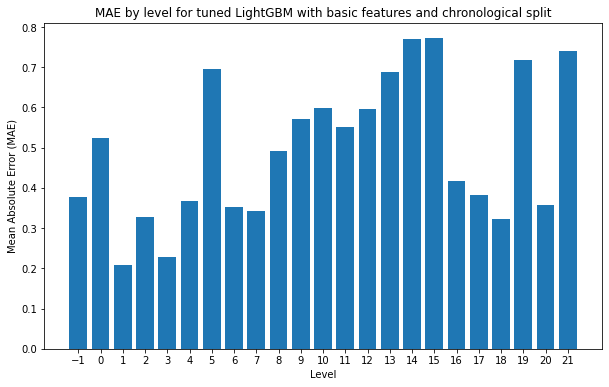

In [76]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and chronological split",
)

In [77]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.51
RMSE: 0.71

Round type: round
MSE: 0.54
RMSE: 0.73

Round type: 0.33
MSE: 0.50
RMSE: 0.71

Round type: 0.45
MSE: 0.50
RMSE: 0.71



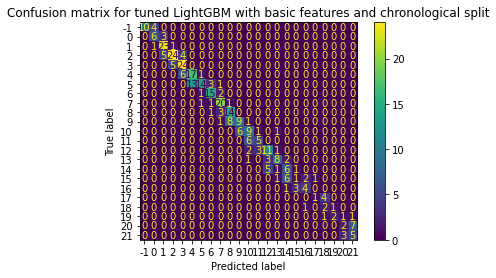

In [78]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with basic features and chronological split",
)

## Random split

In [79]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 8
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 0.340495	valid_0's l2: 0.243018


In [80]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.24
RMSE: 0.49
MAE: 0.34


In [82]:
results.loc[2] = ["random", "default", "basic", mse, rmse, mae]

###### MAE by level

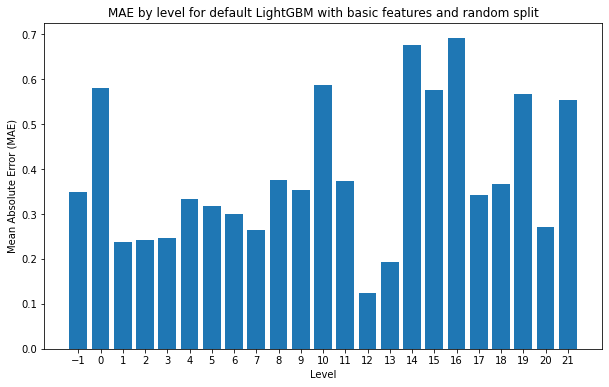

In [83]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and random split",
)

In [84]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.24
RMSE: 0.49

Round type: round
MSE: 0.26
RMSE: 0.51

Round type: 0.33
MSE: 0.32
RMSE: 0.57

Round type: 0.45
MSE: 0.27
RMSE: 0.52



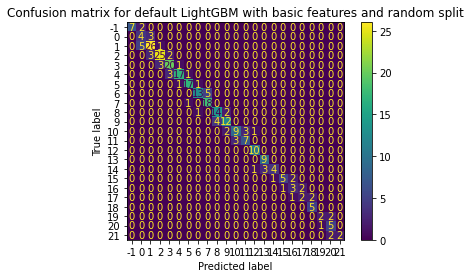

In [85]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with basic features and random split",
)

### Tuning

In [86]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-04 19:59:45,061] A new study created in memory with name: no-name-43c78bf9-6152-4238-8325-9511abcc2619
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.245747 + 0.0700926


feature_fraction, val_score: 0.245054:  14%|######4                                      | 1/7 [00:02<00:16,  2.67s/it]

[200]	cv_agg's l2: 0.252172 + 0.065151
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.245054 + 0.0697045
[100]	cv_agg's l2: 0.235573 + 0.0572204


feature_fraction, val_score: 0.234457:  29%|############8                                | 2/7 [00:04<00:11,  2.39s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.256328 + 0.0777765


feature_fraction, val_score: 0.234457:  43%|###################2                         | 3/7 [00:07<00:09,  2.35s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235573 + 0.0572204


feature_fraction, val_score: 0.234457:  57%|#########################7                   | 4/7 [00:09<00:06,  2.31s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.31295 + 0.0430693


feature_fraction, val_score: 0.234457:  71%|################################1            | 5/7 [00:11<00:04,  2.33s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.247596 + 0.0354955


feature_fraction, val_score: 0.234457:  86%|######################################5      | 6/7 [00:14<00:02,  2.32s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.245873 + 0.0533179


feature_fraction, val_score: 0.234457: 100%|#############################################| 7/7 [00:16<00:00,  2.34s/it]


Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802


num_leaves, val_score: 0.234457:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:   5%|##5                                               | 1/20 [00:02<00:44,  2.35s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:  10%|#####                                             | 2/20 [00:04<00:41,  2.32s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:  15%|#######5                                          | 3/20 [00:06<00:38,  2.29s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:  20%|##########                                        | 4/20 [00:09<00:37,  2.32s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.236442 + 0.0512128


num_leaves, val_score: 0.234457:  25%|############5                                     | 5/20 [00:10<00:29,  1.94s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:  30%|###############                                   | 6/20 [00:13<00:29,  2.14s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802


num_leaves, val_score: 0.234457:  30%|###############                                   | 6/20 [00:13<00:29,  2.14s/it]

[100]	cv_agg's l2: 0.276198 + 0.0735882
Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802


num_leaves, val_score: 0.234457:  35%|#################5                                | 7/20 [00:13<00:20,  1.58s/it]

[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:  40%|####################                              | 8/20 [00:16<00:22,  1.88s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:  45%|######################5                           | 9/20 [00:18<00:22,  2.02s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:  50%|########################5                        | 10/20 [00:20<00:20,  2.07s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:  55%|##########################9                      | 11/20 [00:22<00:19,  2.12s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:  60%|#############################4                   | 12/20 [00:25<00:17,  2.22s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:  65%|###############################8                 | 13/20 [00:27<00:16,  2.29s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:  70%|##################################3              | 14/20 [00:30<00:13,  2.32s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:  75%|####################################7            | 15/20 [00:32<00:11,  2.36s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:  80%|#######################################2         | 16/20 [00:35<00:09,  2.47s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:  85%|#########################################6       | 17/20 [00:38<00:07,  2.58s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:  90%|############################################1    | 18/20 [00:39<00:04,  2.35s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457:  95%|##############################################5  | 19/20 [00:41<00:02,  2.16s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.235003 + 0.0575921


num_leaves, val_score: 0.234457: 100%|#################################################| 20/20 [00:43<00:00,  2.16s/it]


Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802


bagging, val_score: 0.234457:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.273541 + 0.0503771


bagging, val_score: 0.234457:  10%|#####3                                               | 1/10 [00:01<00:09,  1.03s/it]

Early stopping, best iteration is:
[78]	cv_agg's l2: 0.234457 + 0.0593802
[100]	cv_agg's l2: 0.234864 + 0.0545525
[200]	cv_agg's l2: 0.236732 + 0.0494639


bagging, val_score: 0.233066:  20%|##########6                                          | 2/10 [00:03<00:13,  1.63s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.233066 + 0.0528281
[100]	cv_agg's l2: 0.243197 + 0.0612637
[200]	cv_agg's l2: 0.2454 + 0.0570786


bagging, val_score: 0.233066:  30%|###############9                                     | 3/10 [00:05<00:12,  1.85s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.233066 + 0.0528281
[100]	cv_agg's l2: 0.23701 + 0.0574107
[200]	cv_agg's l2: 0.237734 + 0.0535217


bagging, val_score: 0.233066:  40%|#####################2                               | 4/10 [00:07<00:11,  1.94s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.233066 + 0.0528281
[100]	cv_agg's l2: 0.24316 + 0.0561657
[200]	cv_agg's l2: 0.245316 + 0.0502212


bagging, val_score: 0.233066:  50%|##########################5                          | 5/10 [00:08<00:09,  1.85s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.233066 + 0.0528281
[100]	cv_agg's l2: 0.244692 + 0.0549047
[200]	cv_agg's l2: 0.243819 + 0.0505308


bagging, val_score: 0.233066:  60%|###############################8                     | 6/10 [00:10<00:07,  1.80s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.233066 + 0.0528281
[100]	cv_agg's l2: 0.275849 + 0.0445688


bagging, val_score: 0.233066:  60%|###############################8                     | 6/10 [00:11<00:07,  1.80s/it]

[200]	cv_agg's l2: 0.268386 + 0.0474963
Early stopping, best iteration is:
[131]	cv_agg's l2: 0.233066 + 0.0528281


bagging, val_score: 0.233066:  70%|#####################################                | 7/10 [00:11<00:04,  1.65s/it]

[100]	cv_agg's l2: 0.238796 + 0.0538904
[200]	cv_agg's l2: 0.243093 + 0.0489836


bagging, val_score: 0.233066:  80%|##########################################4          | 8/10 [00:13<00:03,  1.74s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.233066 + 0.0528281
[100]	cv_agg's l2: 0.257131 + 0.0465777


bagging, val_score: 0.233066:  80%|##########################################4          | 8/10 [00:15<00:03,  1.74s/it]

[200]	cv_agg's l2: 0.251767 + 0.0459247
Early stopping, best iteration is:
[131]	cv_agg's l2: 0.233066 + 0.0528281


bagging, val_score: 0.233066:  90%|###############################################7     | 9/10 [00:15<00:01,  1.66s/it]

[100]	cv_agg's l2: 0.232392 + 0.046707
[200]	cv_agg's l2: 0.234981 + 0.0483334


bagging, val_score: 0.231275: 100%|####################################################| 10/10 [00:17<00:00,  1.74s/it]


Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932


feature_fraction_stage2, val_score: 0.231275:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.232392 + 0.046707
[200]	cv_agg's l2: 0.234981 + 0.0483334


feature_fraction_stage2, val_score: 0.231275:  17%|######3                               | 1/6 [00:01<00:09,  1.86s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.232392 + 0.046707
[200]	cv_agg's l2: 0.234981 + 0.0483334


feature_fraction_stage2, val_score: 0.231275:  33%|############6                         | 2/6 [00:03<00:07,  1.89s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.25082 + 0.0513223
[200]	cv_agg's l2: 0.247666 + 0.0505168


feature_fraction_stage2, val_score: 0.231275:  50%|###################                   | 3/6 [00:05<00:05,  1.85s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.232392 + 0.046707
[200]	cv_agg's l2: 0.234981 + 0.0483334


feature_fraction_stage2, val_score: 0.231275:  67%|#########################3            | 4/6 [00:07<00:03,  1.86s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.25082 + 0.0513223
[200]	cv_agg's l2: 0.247666 + 0.0505168


feature_fraction_stage2, val_score: 0.231275:  83%|###############################6      | 5/6 [00:09<00:01,  1.83s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.25082 + 0.0513223
[200]	cv_agg's l2: 0.247666 + 0.0505168


feature_fraction_stage2, val_score: 0.231275: 100%|######################################| 6/6 [00:11<00:00,  1.85s/it]


Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932


regularization_factors, val_score: 0.231275:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.232392 + 0.046707
[200]	cv_agg's l2: 0.234981 + 0.0483334


regularization_factors, val_score: 0.231275:   5%|#9                                    | 1/20 [00:02<00:38,  2.05s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.232392 + 0.046707
[200]	cv_agg's l2: 0.234981 + 0.0483334


regularization_factors, val_score: 0.231275:  10%|###8                                  | 2/20 [00:03<00:35,  1.95s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.232392 + 0.046707
[200]	cv_agg's l2: 0.234981 + 0.0483334


regularization_factors, val_score: 0.231275:  15%|#####7                                | 3/20 [00:05<00:33,  1.96s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.232392 + 0.046707
[200]	cv_agg's l2: 0.234981 + 0.0483334


regularization_factors, val_score: 0.231275:  20%|#######6                              | 4/20 [00:07<00:31,  1.97s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.232392 + 0.046707
[200]	cv_agg's l2: 0.234981 + 0.0483334


regularization_factors, val_score: 0.231275:  25%|#########5                            | 5/20 [00:09<00:29,  1.95s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.232392 + 0.046707
[200]	cv_agg's l2: 0.234981 + 0.0483334


regularization_factors, val_score: 0.231275:  30%|###########4                          | 6/20 [00:11<00:27,  1.96s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.232392 + 0.046707
[200]	cv_agg's l2: 0.234981 + 0.0483334


regularization_factors, val_score: 0.231275:  35%|#############3                        | 7/20 [00:13<00:25,  1.96s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.232392 + 0.046707
[200]	cv_agg's l2: 0.234981 + 0.0483334


regularization_factors, val_score: 0.231275:  40%|###############2                      | 8/20 [00:15<00:23,  1.94s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.232392 + 0.046707
[200]	cv_agg's l2: 0.234981 + 0.0483334


regularization_factors, val_score: 0.231275:  45%|#################1                    | 9/20 [00:17<00:21,  1.94s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.232392 + 0.046707
[200]	cv_agg's l2: 0.234981 + 0.0483334


regularization_factors, val_score: 0.231275:  50%|##################5                  | 10/20 [00:20<00:21,  2.15s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.232392 + 0.046707
[200]	cv_agg's l2: 0.234981 + 0.0483334


regularization_factors, val_score: 0.231275:  55%|####################3                | 11/20 [00:22<00:18,  2.06s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.232392 + 0.046707


regularization_factors, val_score: 0.231275:  60%|######################2              | 12/20 [00:23<00:16,  2.02s/it]

[200]	cv_agg's l2: 0.234981 + 0.0483334
Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.232392 + 0.0467071


regularization_factors, val_score: 0.231275:  65%|########################             | 13/20 [00:25<00:12,  1.75s/it]

[200]	cv_agg's l2: 0.234981 + 0.0483334
Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.233208 + 0.0471955


regularization_factors, val_score: 0.231275:  70%|#########################9           | 14/20 [00:26<00:09,  1.58s/it]

[200]	cv_agg's l2: 0.235619 + 0.0486622
Early stopping, best iteration is:
[133]	cv_agg's l2: 0.231275 + 0.0494932
[100]	cv_agg's l2: 0.231083 + 0.0472134


regularization_factors, val_score: 0.230582:  75%|###########################7         | 15/20 [00:27<00:06,  1.37s/it]

Early stopping, best iteration is:
[97]	cv_agg's l2: 0.230582 + 0.0477494
[100]	cv_agg's l2: 0.236243 + 0.0520548


regularization_factors, val_score: 0.230582:  80%|#############################6       | 16/20 [00:28<00:05,  1.37s/it]

Early stopping, best iteration is:
[97]	cv_agg's l2: 0.230582 + 0.0477494
[100]	cv_agg's l2: 0.232392 + 0.046707


regularization_factors, val_score: 0.230582:  85%|###############################4     | 17/20 [00:30<00:04,  1.49s/it]

Early stopping, best iteration is:
[97]	cv_agg's l2: 0.230582 + 0.0477494
[100]	cv_agg's l2: 0.230181 + 0.0470723


regularization_factors, val_score: 0.228625:  90%|#################################3   | 18/20 [00:31<00:03,  1.52s/it]

Early stopping, best iteration is:
[92]	cv_agg's l2: 0.228625 + 0.0470624
[100]	cv_agg's l2: 0.230389 + 0.0469149


regularization_factors, val_score: 0.228625:  95%|###################################1 | 19/20 [00:33<00:01,  1.61s/it]

Early stopping, best iteration is:
[92]	cv_agg's l2: 0.228625 + 0.0470624
[100]	cv_agg's l2: 0.233966 + 0.048699


regularization_factors, val_score: 0.228625: 100%|#####################################| 20/20 [00:35<00:00,  1.76s/it]


Early stopping, best iteration is:
[92]	cv_agg's l2: 0.228625 + 0.0470624


min_data_in_leaf, val_score: 0.228625:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.253704 + 0.0583534


min_data_in_leaf, val_score: 0.228625:  20%|#########                                    | 1/5 [00:01<00:05,  1.34s/it]

Early stopping, best iteration is:
[92]	cv_agg's l2: 0.228625 + 0.0470624
[100]	cv_agg's l2: 0.228715 + 0.0456782


min_data_in_leaf, val_score: 0.228158:  40%|##################                           | 2/5 [00:03<00:05,  1.91s/it]

[200]	cv_agg's l2: 0.231862 + 0.0444119
Early stopping, best iteration is:
[107]	cv_agg's l2: 0.228158 + 0.0453239
[100]	cv_agg's l2: 0.233112 + 0.0560173


min_data_in_leaf, val_score: 0.228158:  60%|###########################                  | 3/5 [00:06<00:04,  2.13s/it]

[200]	cv_agg's l2: 0.236182 + 0.0522548
Early stopping, best iteration is:
[107]	cv_agg's l2: 0.228158 + 0.0453239
[100]	cv_agg's l2: 0.984027 + 0.136445


min_data_in_leaf, val_score: 0.228158:  80%|####################################         | 4/5 [00:06<00:01,  1.51s/it]

[200]	cv_agg's l2: 0.92976 + 0.12885
Early stopping, best iteration is:
[107]	cv_agg's l2: 0.228158 + 0.0453239
[100]	cv_agg's l2: 0.353489 + 0.0731185


min_data_in_leaf, val_score: 0.228158: 100%|#############################################| 5/5 [00:07<00:00,  1.48s/it]

[200]	cv_agg's l2: 0.345287 + 0.0719471
Early stopping, best iteration is:
[107]	cv_agg's l2: 0.228158 + 0.0453239


In [87]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.22815750269102955
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 5.645963790278708e-07
    lambda_l2: 0.003029337424980951
    num_leaves: 31
    feature_fraction: 0.7
    bagging_fraction: 0.865593127468426
    bagging_freq: 1
    min_child_samples: 5


In [88]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [89]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.50
MSE test: 0.25
MAE test: 0.34



In [90]:
results.loc[3] = ["random", "Optuna", "basic", mse, rmse, mae]

###### MAE by level

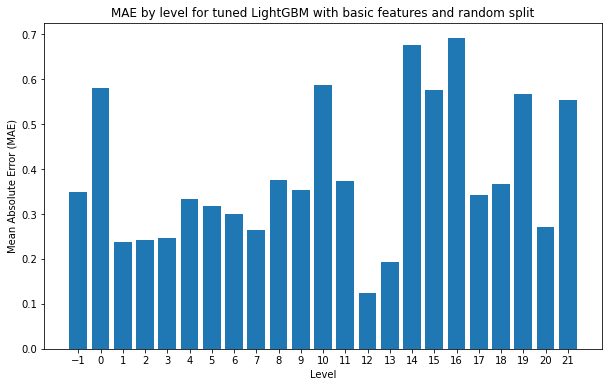

In [91]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and random split",
)

In [92]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.12
RMSE: 0.34

Round type: round
MSE: 0.14
RMSE: 0.37

Round type: 0.33
MSE: 0.16
RMSE: 0.40

Round type: 0.45
MSE: 0.14
RMSE: 0.38



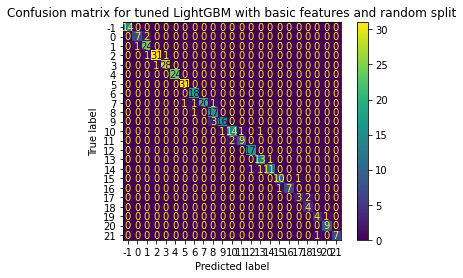

In [93]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with basic features and random split",
)

## Summary

In [94]:
results

,Split type,Tuning type,Set of features,MSE,RMSE,MAE
0,chronological,default,basic,0.447566,0.669004,0.467604
1,chronological,Optuna,basic,0.508115,0.712822,0.513761
2,random,default,basic,0.243018,0.492968,0.340495
3,random,Optuna,basic,0.254976,0.504952,0.335668


In [95]:
from training.results import plot_summary

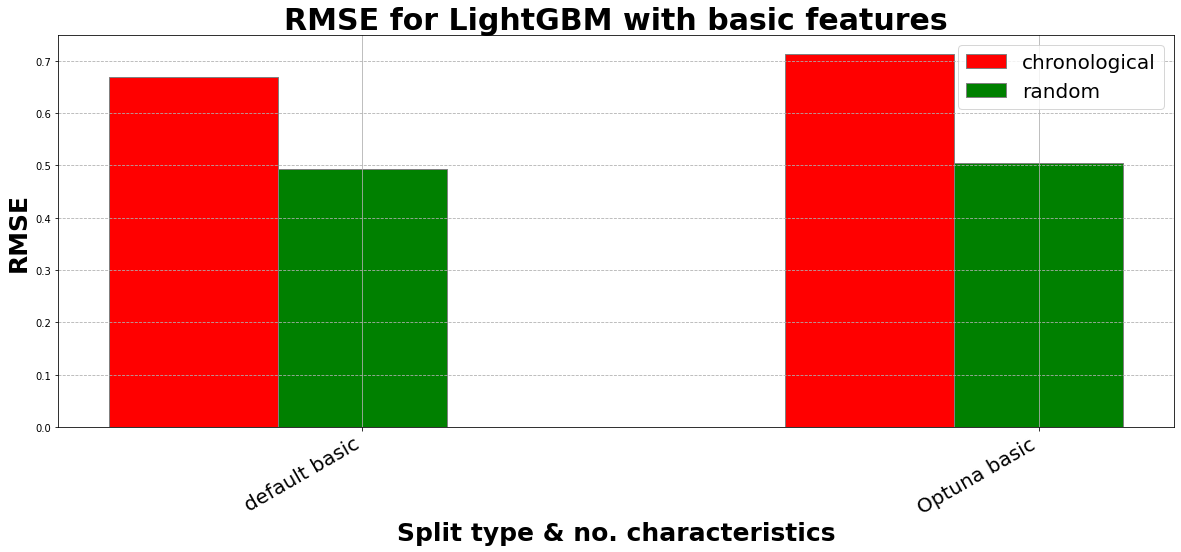

In [96]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with basic features")

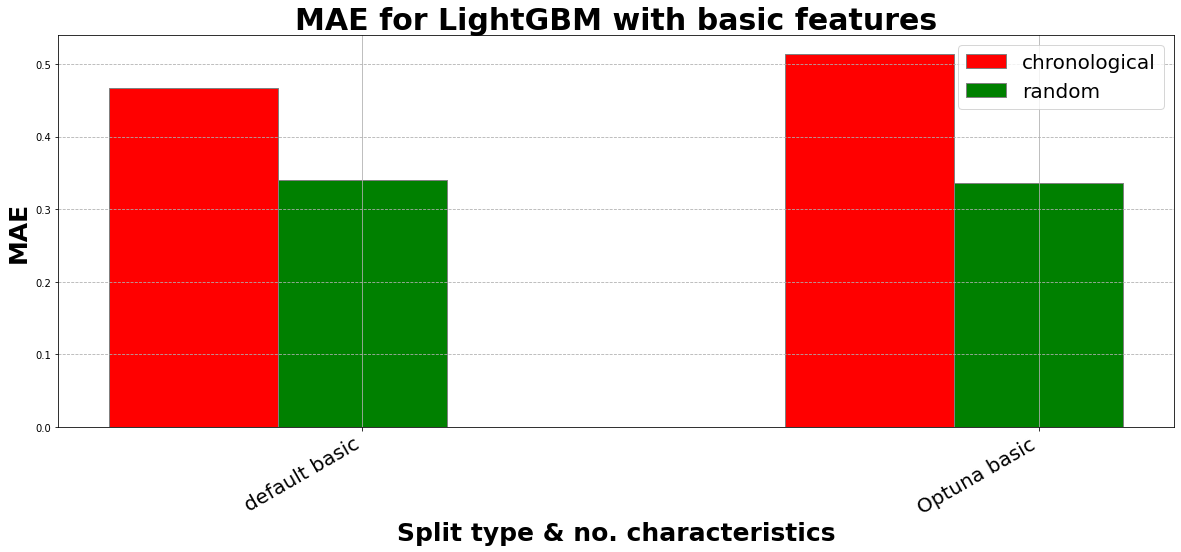

In [97]:
plot_summary(results, "MAE", title="MAE for LightGBM with basic features")

In [98]:
results.to_json("./lightgbm_basic_results.json")